In [27]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately.
from pyvis.network import Network

## Importando dados do CDA Cotas de Fundos

In [26]:
df = pd.read_csv("../../data/funds/funds.csv", sep = ";", decimal=",", encoding="latin1")

## Selecionando apenas as colunas necessárias

In [119]:
funds = df[["CNPJ_FUNDO", "DENOM_SOCIAL", "VL_MERC_POS_FINAL", "CNPJ_FUNDO_COTA", "NM_FUNDO_COTA"]]
funds["CNPJ_FUNDO_COTA"] = funds["CNPJ_FUNDO_COTA"].astype(str)
funds["CNPJ_FUNDO"] = funds["CNPJ_FUNDO"].astype(str)


<ipython-input-119-d60e452b8e02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funds["CNPJ_FUNDO_COTA"] = funds["CNPJ_FUNDO_COTA"].astype(str)
<ipython-input-119-d60e452b8e02>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funds["CNPJ_FUNDO"] = funds["CNPJ_FUNDO"].astype(str)


## Importando Dimensão e criando dicionário de cores

In [29]:
dim_funds = pd.read_csv("../../data/funds/dim_funds.csv", sep = ";", decimal=",", encoding="latin1")
dim_funds["CNPJ_FUNDO"] = dim_funds["CNPJ_FUNDO"].astype(str)
dim_funds = dim_funds.set_index("CNPJ_FUNDO")
colors = {"Multimercados" : "#fc91d17",
            "Ações": "#4c4d4f",
            "Renda Fixa" : "#0095d9",
            "Cambial" : "#66697a",
            "Previdência" : "#80c342",
            "FIP" : "#ffdf4f",
            "FIDC" : "#bfd730",
            "ETF"  : "#de761c",
            "FII" : "03bfd7",
            "Não Encontrado" : "c1c1c1"}

## Normalizando os dados que serão utilizados nas Edges

In [121]:
min_max_scaler = MinMaxScaler()
normalized = min_max_scaler.fit_transform(funds[["VL_MERC_POS_FINAL"]])
funds["WEIGHT"] = normalized
funds["WEIGHT"] = funds["WEIGHT"] * 10000

<ipython-input-121-a60cf6bf102d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funds["WEIGHT"] = normalized
<ipython-input-121-a60cf6bf102d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funds["WEIGHT"] = funds["WEIGHT"] * 10000


## Criando Graph com todos os dados para gerar as Communities

In [122]:
G = nx.from_pandas_edgelist(df = funds, source = "CNPJ_FUNDO", target = "CNPJ_FUNDO_COTA", create_using=nx.Graph())


## Algoritmo de [Clauset-Newman-Moore](http://ece-research.unm.edu/ifis/papers/community-moore.pdf)

In [123]:
communities = community.greedy_modularity_communities(G)

## Selecionando Communities para plotagem

In [124]:
funds_unique = pd.concat([funds[["CNPJ_FUNDO", "DENOM_SOCIAL"]], 
                        funds[["CNPJ_FUNDO_COTA", "NM_FUNDO_COTA"]].rename(columns = {"CNPJ_FUNDO_COTA" : "CNPJ_FUNDO", "NM_FUNDO_COTA" : "DENOM_SOCIAL"})]).drop_duplicates()

In [125]:
funds_dict = {row["DENOM_SOCIAL"] : row["CNPJ_FUNDO"] for index, row in funds_unique.iterrows()}

In [126]:
#comm_filter = [comm for comm in communities if funds_dict["VERDE MASTER FUNDO DE INVESTIMENTO MULTIMERCADO"] in comm]
#funds_comm = comm_filter[0]

In [127]:
comm_sample = [comm for comm in communities if len(comm) > 10 and len(comm) < 20]
funds_comm = funds[funds["CNPJ_FUNDO"].isin(comm_sample[0])]


## Criando um Graph Direcionado com a Community selecionada

In [128]:
G_comm = nx.from_pandas_edgelist(df = funds_comm, source = "CNPJ_FUNDO", target = "CNPJ_FUNDO_COTA", edge_attr= "WEIGHT",create_using=nx.DiGraph())

## Criando dataset com PL dos fundos

In [130]:
funds_group = funds_comm.groupby(["CNPJ_FUNDO", "DENOM_SOCIAL"]).sum().drop(columns = ["WEIGHT"]).reset_index()
funds_group_missing = funds_comm[~funds_comm["CNPJ_FUNDO_COTA"].isin(funds_group["CNPJ_FUNDO"].to_list())].groupby(["CNPJ_FUNDO_COTA", "NM_FUNDO_COTA"]).sum().drop(columns = ["WEIGHT"]).reset_index().rename(columns = {"CNPJ_FUNDO_COTA" : "CNPJ_FUNDO", "NM_FUNDO_COTA" : "DENOM_SOCIAL"})
funds_values = pd.concat([funds_group, funds_group_missing])
funds_values = funds_values.set_index("CNPJ_FUNDO")

In [131]:
min_max_scaler = MinMaxScaler()
normalized = min_max_scaler.fit_transform(funds_values[["VL_MERC_POS_FINAL"]])
funds_values["WEIGHT"] = normalized
funds_values["WEIGHT"] = funds_values["WEIGHT"] * 1000

## Criando Lista com tamanhos dos Nodes

In [132]:
nodes_size = [funds_values.loc[node][2] for node in G_comm.nodes()]

## Criando Lista com tamanho das Edges

In [133]:
edges_width = [d["WEIGHT"] for s, t, d in G_comm.edges(data = True)]

## Plotagem do Graph

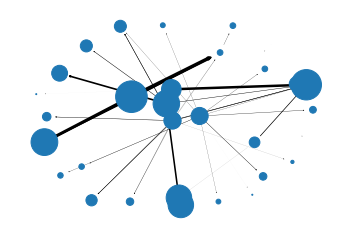

In [134]:

pos = nx.spring_layout(G_comm) 

nx.draw_networkx_nodes(G_comm, pos, node_size=nodes_size)

nx.draw_networkx_edges(G_comm, pos, width=edges_width, arrowsize=2)

plt.axis("off")
plt.show()





## [Pyvis](https://pyvis.readthedocs.io/en/latest/)

In [135]:
G2 = Network(directed=True, height = "800px", width = "100%")
G2.from_nx(G_comm)

In [136]:
for node in G2.nodes:
    node["value"] = funds_values.loc[node["id"]][2]
    node["title"] = funds_values.loc[node["id"]][0]
    node["color"] = colors[dim_funds.loc[node["id"]][1]]

In [137]:
G2.show_buttons(filter_ = ["physics"])
G2.show("arvore_fundos.html")

## [Netwulf](https://netwulf.readthedocs.io/en/latest/)